<a target="_blank" href="https://colab.research.google.com/github/retowuest/uio-dl-2024/blob/main/Notebooks/nb-1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Learning for Social Scientists

### University of Oslo, November 27-28, 2024

### **Demo 1 & 2:**<br>1D Linear Regression and Gradient Descent

### Table of Contents
* [Introduction](#section_1)
* [Creating a Toy Data Set](#section_2)
* [Fitting a 1D Linear Regression Model](#section_3)
  * [Analytical Optimization via `scikit-learn`](#section_3_1)
  * [Numerical Optimization via Gradient Descent (w/ Python)](#section_3_2)
  * [Numerical Optimization via Stochastic Gradient Descent (w/ PyTorch)](#section_3_3)

### Introduction <a class="anchor" id="section_1"></a>

To introduce Python and PyTorch, we will train a 1D linear regression model on a toy data set.

The 1D linear regression model describes the relationship between input $x$ and output $y$ as a straight line,
$$
\begin{split}
y &= f[x, \boldsymbol{\phi}] \\
&= \phi_{0} + \phi_{1}x.
\end{split}
$$

The model parameters are $\boldsymbol{\phi} = [\phi_{0}, \phi_{1}]^{T}$.

Our goal is to choose parameters $\boldsymbol{\hat{\phi}}$ that map input $x$ to output $y$ as closely as possible on a training data set $\mathcal{S} = \{(x_{i}, y_{i})\}_{i = 1}^{N}$. We use least squares as the loss function $L[\boldsymbol{\phi}]$ and find the parameter values that minimize $L[\boldsymbol{\phi}]$ on $\mathcal{S}$,
$$
\begin{split}
\boldsymbol{\hat{\phi}} &= \underset{\boldsymbol{\phi}}{\mathrm{argmin}}\big[L[\boldsymbol{\phi}]\big] \\
&= \underset{\boldsymbol{\phi}}{\mathrm{argmin}}\Bigg[\sum_{i = 1}^{N}(f[x_{i}, \boldsymbol{\phi}] - y_{i})^{2}\Bigg] \\
&= \underset{\boldsymbol{\phi}}{\mathrm{argmin}}\Bigg[\sum_{i = 1}^{N}(\phi_{0} + \phi_{1}x_{i} - y_{i})^{2}\Bigg].
\end{split}
$$

### Creating a Toy Data Set <a class="anchor" id="section_2"></a>

We first create a toy data set with `numpy` and visualize it. This toy data set will serve as our training data set $\mathcal{S} = \{(x_{i}, y_{i})\}_{i = 1}^{N}$.

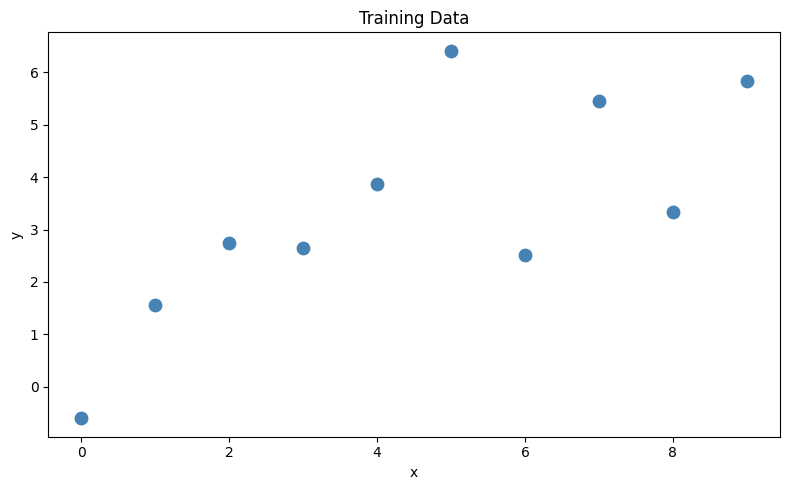

In [ ]:
# Import numpy library and
# pyplot module from the matplotlib library
import numpy as np
import matplotlib.pyplot as plt

# Magic command for setting matplotlib backend to inline backend
# (this will display a plot inline within the notebook,
# directly below the code cell that produced it)
%matplotlib inline

# Create toy data set, data type is no.float32, reshape to 10 by 1 matrix (column vector)
x_train = np.arange(10, dtype=np.float32).reshape((10, 1))

phi0 = 1
phi1 = 0.5

rng = np.random.default_rng(seed=1234)
y_train = (phi0 + phi1 * x_train +
           rng.normal(loc=0, scale=1, size=10).astype(np.float32).reshape(10, 1)) # add noise from rng.normal

# Plot training data
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, c="steelblue", s=80)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training Data")
plt.tight_layout()
plt.show()

### Fitting a 1D Linear Regression Model <a class="anchor" id="section_3"></a>

#### Analytical Optimization via `scikit-learn` <a class="anchor" id="section_3_1"></a>

The 1D linear regression model with a least-squares loss function has a closed-form solution to the optimization problem. The parameter values that minimize the loss function are:
$$
\begin{split}
\hat{\phi}_{0} &= \bar{y} - \hat{\phi}_{1}\bar{x} \\
\hat{\phi}_{1} &= \frac{\sum_{i = 1}^{N}(x_{i} - \bar{x})(y_{i} - \bar{y})}{\sum_{i = 1}^{N}(x_{i} - \bar{x})^{2}},
\end{split}
$$
where $\bar{x} = \frac{1}{N}\sum_{i = 1}^{N}x_{i}$ and $\bar{y} = \frac{1}{N}\sum_{i = 1}^{N}y_{i}$ are the sample means.

We use `scikit-learn` to find the least-squares estimates. Note that `scikit-learn` relies on the function `scipy.linalg.lstsq`, which computes the least-squares solution to the normal equations.

In [ ]:
# Import class LinearRegression from the module linear_model
# in the scikit-learn library
from sklearn.linear_model import LinearRegression

# Create instance of class LinearRegression
lm_skl = LinearRegression()

# Train model on training data
lm_skl.fit(x_train, y_train)

# Print trained model parameters
print(f"Intercept: {lm_skl.intercept_[0]:.2f}")
print(f"Slope: {lm_skl.coef_[0][0]:.2f}")

Intercept: 1.03
Slope: 0.52


We can now plot the training data together with the fitted regression line defined by the least-squares parameter estimates.

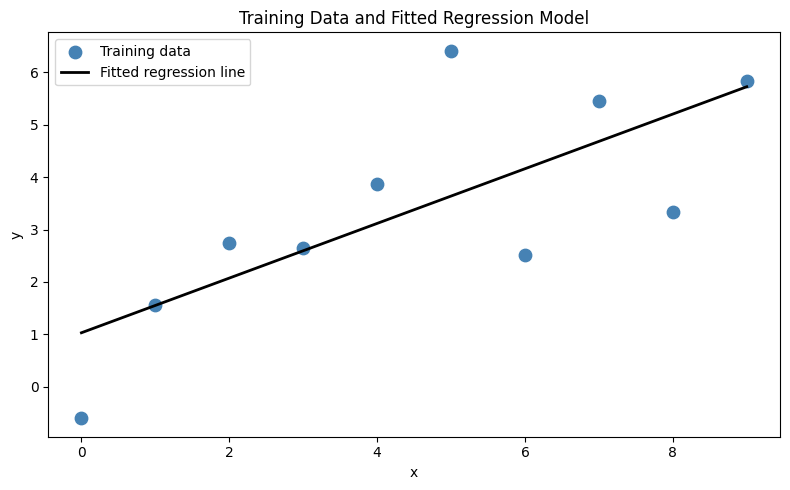

In [ ]:
# Plot training data together with fitted regression line
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, c="steelblue", s=80)
plt.plot(x_train, lm_skl.predict(x_train), color="black", lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training Data and Fitted Regression Model")
plt.legend(["Training data", "Fitted regression line"])
plt.tight_layout()
plt.show()

#### Numerical Optimization via Gradient Descent (w/ Python) <a class="anchor" id="section_3_2"></a>

Next, let's train a 1D linear regression model using gradient descent in Python. We will take an object-oriented programming (OOP) approach and implement the gradient descent algorithm as a [Python class](https://realpython.com/python-classes/).

We first standardize the input for better convergence of the algorithm.

In [ ]:
# Standardize input
# (We do this manually here. Alternatively, we could use the StandardScaler class
# from scikit-learn's preprocessing module)
x_train_std = (x_train - np.mean(x_train)) / np.std(x_train)

In [ ]:
# Implement gradient descent algorithm
class LinearRegressionGD:

    # The __init__() method is a constructor method in Python classes.
    # It initializes an object when it is created and allows us to assign
    # values to the object's attributes
    # (The first argument of most classes is self. This argument holds a
    # reference to the current object so that we can use it inside the class)
    def __init__(self, alpha=0.001, n_iter=2000, seed=1):
        self.alpha = alpha
        self.n_iter = n_iter
        self.seed = seed

    # Define fit() method that can be applied to objects of our class
    def fit(self, x, y):
        rng = np.random.default_rng(seed=self.seed)
        self.phi1_ = rng.normal(loc=0, scale=1, size=x.shape[1]).reshape(1, 1)
        self.phi0_ = np.zeros((1, 1))
        self.losses_ = []

        # Loop over iterations (epochs)
        for i in range(self.n_iter):
            # Generate predictions
            output = self.net_input(x)
            # Calculate errors
            errors = (output - y)
            # Update model parameters using gradients
            self.phi1_ -= self.alpha * 2.0 * x.T.dot(errors) / x.shape[0]
            self.phi0_ -= self.alpha * 2.0 * errors.mean().reshape(1, 1)
            # Calculate loss
            loss = (errors**2).mean()
            # Store current loss
            self.losses_.append(loss)
        return self

    def net_input(self, x):
        return self.phi0_ + np.dot(x, self.phi1_)

Let's now train our gradient descent algorithm on the standardized training data.

In [ ]:
%%capture

# Instantiate class LinearRegressionGD
lm_gd = LinearRegressionGD(alpha=0.001)

# Train model on standardized training data
lm_gd.fit(x_train_std, y_train)

To check whether the gradient descent algorithm converged to the global minimum of the loss function, we plot the loss by epoch (iteration) over the training data set. As we can see, the algorithm converged approximately after the 1,000th epoch.

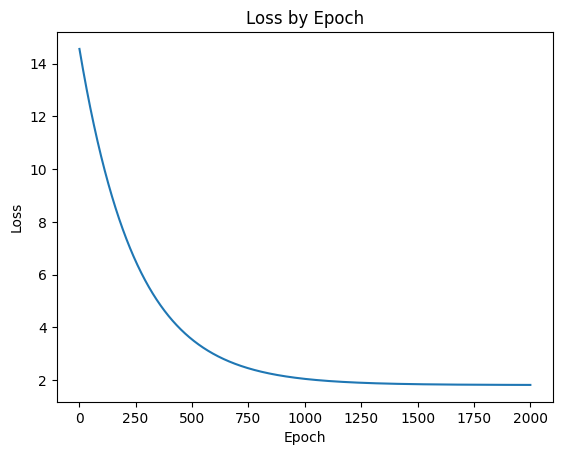

In [ ]:
# Plot loss by epoch
plt.plot(range(1, lm_gd.n_iter + 1), lm_gd.losses_)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss by Epoch")
plt.show()

Let's take a look at the fitted parameters of the 1D linear regression model.

In [ ]:
# Print trained model parameters
print(f"Intercept: {lm_gd.phi0_[0, 0]:.2f}")
print(f"Slope: {lm_gd.phi1_[0, 0]:.2f}")

Intercept: 3.32
Slope: 1.48


We trained the model with a standardized input, which changes the estimates of the model parameters. To make the results comparable to the earlier results from training with unstandardized input, we transform the estimates back to the original scale:
$$
\begin{split}
\hat{\phi}_{0}^{\text{original}} &= \hat{\phi}_{0} - \hat{\phi}_{1}\frac{\bar{x}}{\sigma_{x}} \\
\hat{\phi}_{1}^{\text{original}} &= \frac{\hat{\phi}_{1}}{\sigma_{x}},
\end{split}
$$
where $\bar{x}$ is the sample mean and $\sigma_{x}$ is the sample standard deviation of the input.

In [ ]:
# Calculate trained model parameters for unstandardized input
phi0_gd_original = lm_gd.phi0_[0, 0] - lm_gd.phi1_[0, 0] * (np.mean(x_train) / np.std(x_train))
phi1_gd_original = lm_gd.phi1_[0, 0] / np.std(x_train)

print(f"Intercept: {phi0_gd_original:.2f}")
print(f"Slope: {phi1_gd_original:.2f}")

Intercept: 1.00
Slope: 0.51


#### Numerical Optimization via Stochastic Gradient Descent (w/ PyTorch) <a class="anchor" id="section_3_3"></a>


Let's now train a 1D linear regression model using stochastic gradient descent in PyTorch. While neural networks are typically built and trained using the `torch.nn` module from the PyTorch library, we will take a different approach. Instead of relying on `torch.nn` functionalities, we will train our model using only basic PyTorch tensor operations. This will help us better understand the mechanics underlying the `torch.nn` module.

We first convert the input and output from ndarray to tensor and create a `TensorDataset` and a corresponding `DataLoader`.

In [ ]:
# Import torch library
# Import the TensorDataset class and the DataLoader class
# from the torch.utils.data module
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Convert input and output from ndarray to tensor
x_train_std = torch.from_numpy(x_train_std)
y_train = torch.from_numpy(y_train)

# Create TensorDataset
train_ds = TensorDataset(x_train_std, y_train)

# Create DataLoader and set batch size to 1
# (DataLoader() returns an object of the DataLoader class,
# which we can use to iterate through batches of an input data set)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)  # randomly shuffle data at the beginning of each epoch before dividing them into batches

We can now define our 1D linear regression model. Here we would typically use the `torch.nn` module, which provides predefined layers for building neural network models. However, we will proceed by building a linear regression model from scratch.

Note that in PyTorch there is a special object for tensors for which gradients need to be computed. This special tensor object can be created by setting `requires_grad=True`.

In [ ]:
# Set seed
torch.manual_seed(1234)

# Initialize bias and weight parameters
# (the bias and weight are trainable parameters,
# so we need to compute the gradients)
bias = torch.zeros(1, requires_grad=True)

# Note that torch.rand(n) returns a tensor filled with
# n random numbers from a standard normal distribution
weight = torch.randn(1)
weight.requires_grad_()  # this is an alternative method for setting requires_grad=True

# Define linear regression model
def model(xb):
    return bias + xb * weight

We next define the loss function that we want to minimize in the training process. We choose the mean squared error (MSE) as our loss function.

In [ ]:
# Define loss function
def loss_fn(prediction, target):
    return (prediction - target).pow(2).mean()

We will use stochastic gradient descent (SGD) as our training algorithm. SGD requires the computation of gradients. Rather than manually computing the gradients, we will do so by using the `backward()` method from the `torch.autograd` module.

Finally, we set the learning rate and the number of epochs before we train our model.

In [ ]:
# Set learning rate
learning_rate = 0.001

# Set number of epochs
num_epochs = 200

Let's now train the 1D linear regression model on the batched version of the data set.

In [ ]:
# Train linear regression model (w/o torch.nn)

# Specify after how many epochs loss is to be displayed
log_epochs = 10

# Loop over epochs
for epoch in range(num_epochs):

    # Loop over training data batches
    for x_batch, y_batch in train_dl:
        # Generate predictions
        y_batch_pred = model(x_batch)
        # Calculate loss
        loss = loss_fn(y_batch_pred, y_batch)
        # Compute gradients
        # (method backward() computes gradients for model parameters)
        loss.backward()

    # In the below block we update model parameters, so we disable gradient calculation
    # (this will reduce memory consumption)
    with torch.no_grad():
        # Update model parameters using gradients
        bias -= learning_rate * bias.grad
        weight -= learning_rate * weight.grad
        # Reset gradients to zero
        # (the grad attribute contains the gradients computed by backward().
        # Subsequent calls to backward() will accumulate (i.e., add) gradients
        # rather than overwriting them, so we zero out the gradients before
        # moving on to the next iteration)
        bias.grad.zero_()
        weight.grad.zero_()

    # Print loss for every kth epoch
    if epoch % log_epochs==0:  # opertor % is the modulus (i.e., remainder after division of a by b)
        print(f'Epoch {epoch}:   Loss {loss.item():.4f}')  # item() returns the value of a tensor as a standard Python number (works only for tensors with one element)

Epoch 0:   Loss 2.6254
Epoch 10:   Loss 32.9588
Epoch 20:   Loss 27.0230
Epoch 30:   Loss 2.2093
Epoch 40:   Loss 4.5787
Epoch 50:   Loss 1.5180
Epoch 60:   Loss 1.7043
Epoch 70:   Loss 0.4824
Epoch 80:   Loss 0.7180
Epoch 90:   Loss 0.9364
Epoch 100:   Loss 1.4095
Epoch 110:   Loss 1.7216
Epoch 120:   Loss 0.3829
Epoch 130:   Loss 0.9471
Epoch 140:   Loss 2.4511
Epoch 150:   Loss 8.7028
Epoch 160:   Loss 0.1165
Epoch 170:   Loss 2.5529
Epoch 180:   Loss 0.0161
Epoch 190:   Loss 0.5089


Let's look at the trained model parameters.

In [ ]:
# Print trained model parameters
print(f"Intercept: {bias.item():.2f}")
print(f"Slope: {weight.item():.2f}")

Intercept: 3.32
Slope: 1.47


As before, let's calculate the estimates for the input on its original scale.

In [ ]:
# Calculate trained model parameters for unstandardized input
bias_original = bias.item() - weight.item() * (np.mean(x_train) / np.std(x_train))
weight_original = weight.item() / np.std(x_train)

print(f"Intercept: {bias_original:.2f}")
print(f"Slope: {weight_original:.2f}")

Intercept: 1.01
Slope: 0.51


Above, we trained the model by defining a custom loss function `loss_fn()` and applying stochastic gradient descent optimization. However, writing the loss function and gradient updates can be a repetitive task. The `torch.nn` module provides a set of loss functions, and the `torch.optim` module supports most commonly used optimization algorithms. Below, we will train the 1D linear regression model using the `torch.nn` and `torch.optim` modules.

In [ ]:
%%capture
!pip3 install --upgrade ipywidgets

In [ ]:
# Import the torch.nn module
import torch.nn as nn

# Define loss function
loss_fn_nn = nn.MSELoss(reduction="mean")

# Define input and output size for linear layer in the model
input_size = 1
output_size = 1

# Define linear regression model
model_nn = nn.Linear(input_size, output_size)

# Define optimization algorithm
optimizer = torch.optim.SGD(model_nn.parameters(), lr=learning_rate)

We can now call the `step()` method of the optimizer to train the model.

In [ ]:
# Train linear regression model (w/ torch.nn)

# Loop over epochs
for epoch in range(num_epochs):

    # Loop over training data batches
    for x_batch, y_batch in train_dl:
        # Generate predictions
        y_batch_pred = model_nn(x_batch)
        # Calculate loss
        loss = loss_fn_nn(y_batch_pred, y_batch)
        # Compute gradients
        loss.backward()
        # Update model parameters using gradients
        optimizer.step()
        # Reset gradients to zero
        optimizer.zero_grad()

    # Print loss for every kth epoch
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}:   Loss {loss.item():.4f}')

Epoch 0:   Loss 29.2344
Epoch 10:   Loss 9.8993
Epoch 20:   Loss 29.6733
Epoch 30:   Loss 10.9128
Epoch 40:   Loss 0.3254
Epoch 50:   Loss 1.6534
Epoch 60:   Loss 1.1297
Epoch 70:   Loss 0.4364
Epoch 80:   Loss 12.8292
Epoch 90:   Loss 1.3675
Epoch 100:   Loss 1.5437
Epoch 110:   Loss 0.1826
Epoch 120:   Loss 0.8913
Epoch 130:   Loss 2.1507
Epoch 140:   Loss 1.0932
Epoch 150:   Loss 0.0503
Epoch 160:   Loss 0.0376
Epoch 170:   Loss 2.9425
Epoch 180:   Loss 0.7951
Epoch 190:   Loss 0.6898


Let's look at the trained model parameters.

In [ ]:
# Print trained model parameters
print(f"Intercept: {model_nn.bias.item():.2f}")
print(f"Slope: {model_nn.weight.item():.2f}")

Intercept: 3.31
Slope: 1.48


And let's again calculate the estimates for the input on its original scale.

In [ ]:
# Calculate trained model parameters for unstandardized input
bias_nn_original = (model_nn.bias.item() - model_nn.weight.item() *
                    (np.mean(x_train) / np.std(x_train)))
weight_nn_original = model_nn.weight.item() / np.std(x_train)

print(f"Intercept: {bias_nn_original:.2f}")
print(f"Slope: {weight_nn_original:.2f}")

Intercept: 0.98
Slope: 0.52
